<a href="https://colab.research.google.com/github/hits-sdo/hits-sdo-similaritysearch/blob/byol-embeddings-analysis/search_byol/byol_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to Intialize HITS-SDO self-similarity search environment
- Run all cells to initalize environment, and restart runtime if prompted to use updated versions. You will need to rerun the cells again to ensure that all dependencies have been installed.

# Download and Unzip Data

In [1]:
# Download Data - Uncomment the one you want

# 171 with false yellow colors - https://drive.google.com/file/d/15C5spf1la7L09kvWXll2qt67Ec0rwLsY/view?usp=drive_link
# !gdown 15C5spf1la7L09kvWXll2qt67Ec0rwLsY


# 171 grayscale - https://drive.google.com/file/d/16WD0td1f5gx4yIIDkWWSTb-oZcezI1CU/view?usp=drive_link
# !gdown 16WD0td1f5gx4yIIDkWWSTb-oZcezI1CU


# Multiwavelength r:211 g:193 b:171 https://drive.google.com/file/d/1DMIatOmA4XcoWeW0oAUkZujx8YrhLkpY/view?usp=sharing
# !gdown 1DMIatOmA4XcoWeW0oAUkZujx8YrhLkpY
# Multiwavelength r:211 g:193 b:171active cycle extension https://drive.google.com/file/d/1-BPQpdQWNwZzoVpg3lQ143cr3_UPE36M/view?usp=sharing
# !gdown 1-BPQpdQWNwZzoVpg3lQ143cr3_UPE36M

# Multiwavelength r:304 g:211 b:171 https://drive.google.com/file/d/1Pts431S-fdSfJJ6pt79-fkNYazXqO9O7/view?usp=sharing
!gdown 1Pts431S-fdSfJJ6pt79-fkNYazXqO9O7
# Multiwavelength r:304 g:211 b:171 active cycle extension https://drive.google.com/file/d/1Sbbgi6HzJkuCTUF8tJTLeddpGIjGXTcj/view?usp=sharing
# !gdown 1Sbbgi6HzJkuCTUF8tJTLeddpGIjGXTcj


# Multiwavelength r:335 g:193 b:94 https://drive.google.com/file/d/1v0IYSzwiQcHPcnSsTAeU7bI8c4310b35/view?usp=sharing
# !gdown 1v0IYSzwiQcHPcnSsTAeU7bI8c4310b35
# Multiwavelength r:335 g:193 b:94 active cycle extension https://drive.google.com/file/d/1uSt8BzpVj5GgM9SwSsDcQMEE4lv1uTJo/view?usp=sharing
# !gdown 1uSt8BzpVj5GgM9SwSsDcQMEE4lv1uTJo

Downloading...
From: https://drive.google.com/uc?id=1Pts431S-fdSfJJ6pt79-fkNYazXqO9O7
To: /content/AIA304_211_171_Miniset.tar.gz
100% 204M/204M [00:01<00:00, 142MB/s]


In [2]:
# Unzip file make them match the cell above

# 171 with false yellow colors
# !tar -zxf aia_171_color_1perMonth.tar.gz


# 171 grayscale
# !tar -zxf AIA171_Miniset_BW.tar.gz


# Multiwavelength r:211 g:193 b:171
# !tar -zxf AIA211_193_171_Miniset.tar.gz
# Multiwavelength r:211 g:193 b:171active cycle extension
# !tar -zxf AIA211_193_171_Miniset_ext.tar.gz


# Multiwavelength r:304 g:211 b:171
!tar -zxf AIA304_211_171_Miniset.tar.gz
# Multiwavelength r:304 g:211 b:171 active cycle extension
# !tar -zxf AIA304_211_171_Miniset_ext.tar.gz


# Multiwavelength r:335 g:193 b:94
# !tar -zxf AIA335_193_94_Miniset.tar.gz
# Multiwavelength r:335 g:193 b:94 active cycle extension
# !tar -zxf AIA335_193_94_Miniset_ext.tar.gz

In [3]:
# Print some files to see that they exist - match cells above

# 171 with false yellow colors
# !du aia_171_color_1perMonth/. -l -h

# 171 grayscale
# !du AIA171_Miniset_BW/. -l -h

# Multiwavelength r:211 g:193 b:171
# !du AIA211_193_171_Miniset/. -l -h

# Multiwavelength r:304 g:211 b:171
!du AIA304_211_171_Miniset/. -l -h

# Multiwavelength r:335 g:193 b:94
# !du AIA335_193_94_Miniset/. -l -h

3.2M	AIA304_211_171_Miniset/./20151005_000008_aia_304_211_171/tiles
40K	AIA304_211_171_Miniset/./20151005_000008_aia_304_211_171/tile_meta_data
3.2M	AIA304_211_171_Miniset/./20151005_000008_aia_304_211_171
3.2M	AIA304_211_171_Miniset/./20131031_000009_aia_304_211_171/tiles
40K	AIA304_211_171_Miniset/./20131031_000009_aia_304_211_171/tile_meta_data
3.2M	AIA304_211_171_Miniset/./20131031_000009_aia_304_211_171
3.2M	AIA304_211_171_Miniset/./20170807_000007_aia_304_211_171/tiles
40K	AIA304_211_171_Miniset/./20170807_000007_aia_304_211_171/tile_meta_data
3.2M	AIA304_211_171_Miniset/./20170807_000007_aia_304_211_171
3.2M	AIA304_211_171_Miniset/./20190306_000007_aia_304_211_171/tiles
40K	AIA304_211_171_Miniset/./20190306_000007_aia_304_211_171/tile_meta_data
3.2M	AIA304_211_171_Miniset/./20190306_000007_aia_304_211_171
3.2M	AIA304_211_171_Miniset/./20140409_000009_aia_304_211_171/tiles
40K	AIA304_211_171_Miniset/./20140409_000009_aia_304_211_171/tile_meta_data
3.2M	AIA304_211_171_Miniset/./20

# Clone repository

In [4]:
# Clone the repository from GitHub
!git clone https://github.com/hits-sdo/hits-sdo-similaritysearch

Cloning into 'hits-sdo-similaritysearch'...
remote: Enumerating objects: 805, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 805 (delta 234), reused 326 (delta 195), pack-reused 384
Receiving objects: 100% (805/805), 62.79 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (347/347), done.


In [5]:
%cd hits-sdo-similaritysearch/

/content/hits-sdo-similaritysearch


# Switch to Desired Branch

In [6]:
# Switch to the desired branch with requirements.txt
!git checkout byol-embeddings-analysis

Branch 'byol-embeddings-analysis' set up to track remote branch 'byol-embeddings-analysis' from 'origin'.
Switched to a new branch 'byol-embeddings-analysis'


In [7]:
# Confirm that branch is up to date
!git log --oneline

626a955 (HEAD -> byol-embeddings-analysis, origin/byol-embeddings-analysis) Add data type to wandb config and set datapaths
4db3fc2 Add different data alternatives to check
22abf42 Add multi-wavelength downloads to notebooks
2581166 Add seed parameter for reproducibility
ca5ce2f Updated to new dataset file name and add embeddings plot
d2b58c7 Added test to make sure that double augmentation also produces different images
2534ea6 change dataset to return zero when augmentation is 'none'
f90d9ae Merge branch 'byol-embeddings-analysis' of https://github.com/hits-sdo/hits-sdo-similaritysearch into byol-embeddings-analysis
6804358 Changed dataset augmentation options to none, single, and double
0627812 rename database to dataset to be consistent with pytorch conventions
02a851e Don't drop last batch, even if incomplete
a75f541 Update number of workers to take advantage of colab pro plus
372396e (origin/search-byol-experiment-2) Added projection and prediction head output sizes to parameters

# Install all necesary packages into environment

In [8]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hits-sdo/hits-sdo-packager.git (to revision pip_nodata) to /tmp/pip-req-build-fw6lt1cp
  Running command git clone --filter=blob:none --quiet https://github.com/hits-sdo/hits-sdo-packager.git /tmp/pip-req-build-fw6lt1cp
  Running command git checkout -b pip_nodata --track origin/pip_nodata
  Switched to a new branch 'pip_nodata'
  Branch 'pip_nodata' set up to track remote branch 'pip_nodata' from 'origin'.
  Resolved https://github.com/hits-sdo/hits-sdo-packager.git to commit eecfbe18e34961276a5e2aef3a8b2319b796ca9c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.6/647.6 kB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.2 MB/s et

##  Load Modules

In [9]:
import copy
import numpy as np
from tqdm.autonotebook import tqdm

import torch
import torchvision
from torch import nn

import wandb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

from lightly.data import LightlyDataset
from lightly.data.multi_view_collate import MultiViewCollate
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLPredictionHead, BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.utils.scheduler import cosine_schedule

from search_byol.dataset import SDOTilesDataset

<ipython-input-9-6eaaa5b104de>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Login to Wanddb and initialize logger

In [10]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Define run parameters and initalize Wandb

In [11]:
# Set data type and data path.  Make sure it matches cells above

# 171 with false yellow colors
# data_type = '171Color'
# data_path = '/content/aia_171_color_1perMonth'

# 171 grayscale
# data_type = '171gray'
# data_path = '/content/AIA171_Miniset_BW'

# Multiwavelength r:211 g:193 b:171
# data_type = 'r:211 g:193 b:171'
# data_path = '/content/AIA211_193_171_Miniset'

# Multiwavelength r:304 g:211 b:171
data_type = 'r:304 g:211 b:171'
data_path = '/content/AIA304_211_171_Miniset'

# Multiwavelength r:335 g:193 b:94
# data_type = 'r:335 g:193 b:94'
# data_path = '/content/AIA335_193_94_Miniset'

In [12]:
seed = 42
from lightning.pytorch import seed_everything
seed_everything(seed, workers=True)

initial = "AMJ"
job_type = "AMJ"
epochs = 5
data_stride = 10
batch_size = 700
augmentation = 'double'
learning_rate = 0.1
cosine_scheduler_start = .1
cosine_scheduler_end = 1.0
projection_size = 2
prediction_size = 2

notes = "Commit message first experimentation run one"
name = f"{initial}-ds{data_stride}_bs{batch_size}_lr{learning_rate}_{augmentation}aug_ss{cosine_scheduler_start}_se{cosine_scheduler_end}_pjs{projection_size}_pds{prediction_size}"
group = "embedding-size"
tags = ["experimentation"]


wandb.init(
    # set the wandb project where this run will be logged
    project="search-byol-for_real",
    
    # track hyperparameters and run metadata
    config={
    "seed": seed,
    "data_type": data_type,
    "batch size": batch_size,
    "augmention": augmentation,
    "data stride": data_stride,
    "learning_rate": learning_rate,
    "cosine_scheduler_start": cosine_scheduler_start,
    "cosine_scheduler_end": cosine_scheduler_end
    },
    entity = "search-byol",
    job_type = job_type,
    name = name,
    notes = notes,
    group = group,
    tags = tags,

)


INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
wandb: Currently logged in as: amunozj (search-byol). Use `wandb login --relogin` to force relogin


## Define BYOL Model

In [13]:
class BYOL(nn.Module):
    def __init__(self, backbone, projection_size=256, prediction_size=256):
        super().__init__()

        self.backbone = backbone
        self.projection_head = BYOLProjectionHead(512, 1024, projection_size)
        self.prediction_head = BYOLPredictionHead(projection_size, 1024, prediction_size)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z

## Initialize Module

In [14]:
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone, projection_size=projection_size, prediction_size=prediction_size)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BYOL(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

## Initialize Dataloader

In [15]:
dataset = SDOTilesDataset(data_path=data_path, augmentation=augmentation, data_stride=data_stride)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=12,
)

## Run Training Loop 

In [16]:
criterion = NegativeCosineSimilarity()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


avg_loss = np.nan
print("Starting Training")
epoch = 0
epochs_bar = tqdm(range(epochs), dynamic_ncols=True, desc=f'Epoch {epoch:>02} - Av. loss: {avg_loss:.5f}')
for epoch in epochs_bar:
    total_loss = 0
    momentum_val = cosine_schedule(epoch, epochs, cosine_scheduler_start, cosine_scheduler_end)
    batches_bar = tqdm(dataloader, dynamic_ncols=True, leave=True, desc=f'Batches - Av. loss: {avg_loss:.5f}')
    for (x0, x1) in batches_bar:
        update_momentum(model.backbone, model.backbone_momentum, m=momentum_val)
        update_momentum(
            model.projection_head, model.projection_head_momentum, m=momentum_val
        )
        x0 = x0.to(device)
        x1 = x1.to(device)
        p0 = model(x0)
        z0 = model.forward_momentum(x0)
        p1 = model(x1)
        z1 = model.forward_momentum(x1)
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss = total_loss / len(dataloader)
        batches_bar.set_description(f'Epoch {epoch:>02} - Av. loss: {avg_loss:.5f} - Batches')
        batches_bar.refresh()        

    # log metrics to wandb
    wandb.log({"Av. loss": avg_loss})

    epochs_bar.set_description(f'Epoch {epoch:>02} - Av. loss: {avg_loss:.5f}')
    epochs_bar.refresh()

wandb.finish() 

Starting Training


Epoch 00 - Av. loss: nan:   0%|          | 0/5 [00:00<?, ?it/s]

Batches - Av. loss: nan:   0%|          | 0/17 [00:00<?, ?it/s]

Batches - Av. loss: -0.71964:   0%|          | 0/17 [00:00<?, ?it/s]

Batches - Av. loss: -0.91232:   0%|          | 0/17 [00:00<?, ?it/s]

Batches - Av. loss: -0.92129:   0%|          | 0/17 [00:00<?, ?it/s]

Batches - Av. loss: -0.95372:   0%|          | 0/17 [00:00<?, ?it/s]

Av. loss,█▂▂▁▁
Av. loss,-0.96306


## Running inference on dataset without augmentation

In [17]:
dataset_inference = SDOTilesDataset(data_path=data_path, augmentation='none', data_stride=10)

dataloader_inference = torch.utils.data.DataLoader(
    dataset,
    batch_size=len(dataset_inference),
    shuffle=True,
    drop_last=False,
    num_workers=12,
)

In [18]:
data = next(iter(dataloader_inference))[0]
data.shape

torch.Size([11212, 3, 128, 128])

In [19]:
embeddings_inference = model.forward_momentum(data.cuda()).cpu().numpy()
embeddings_inference.shape

(11212, 2)

## Plotting Embeddings

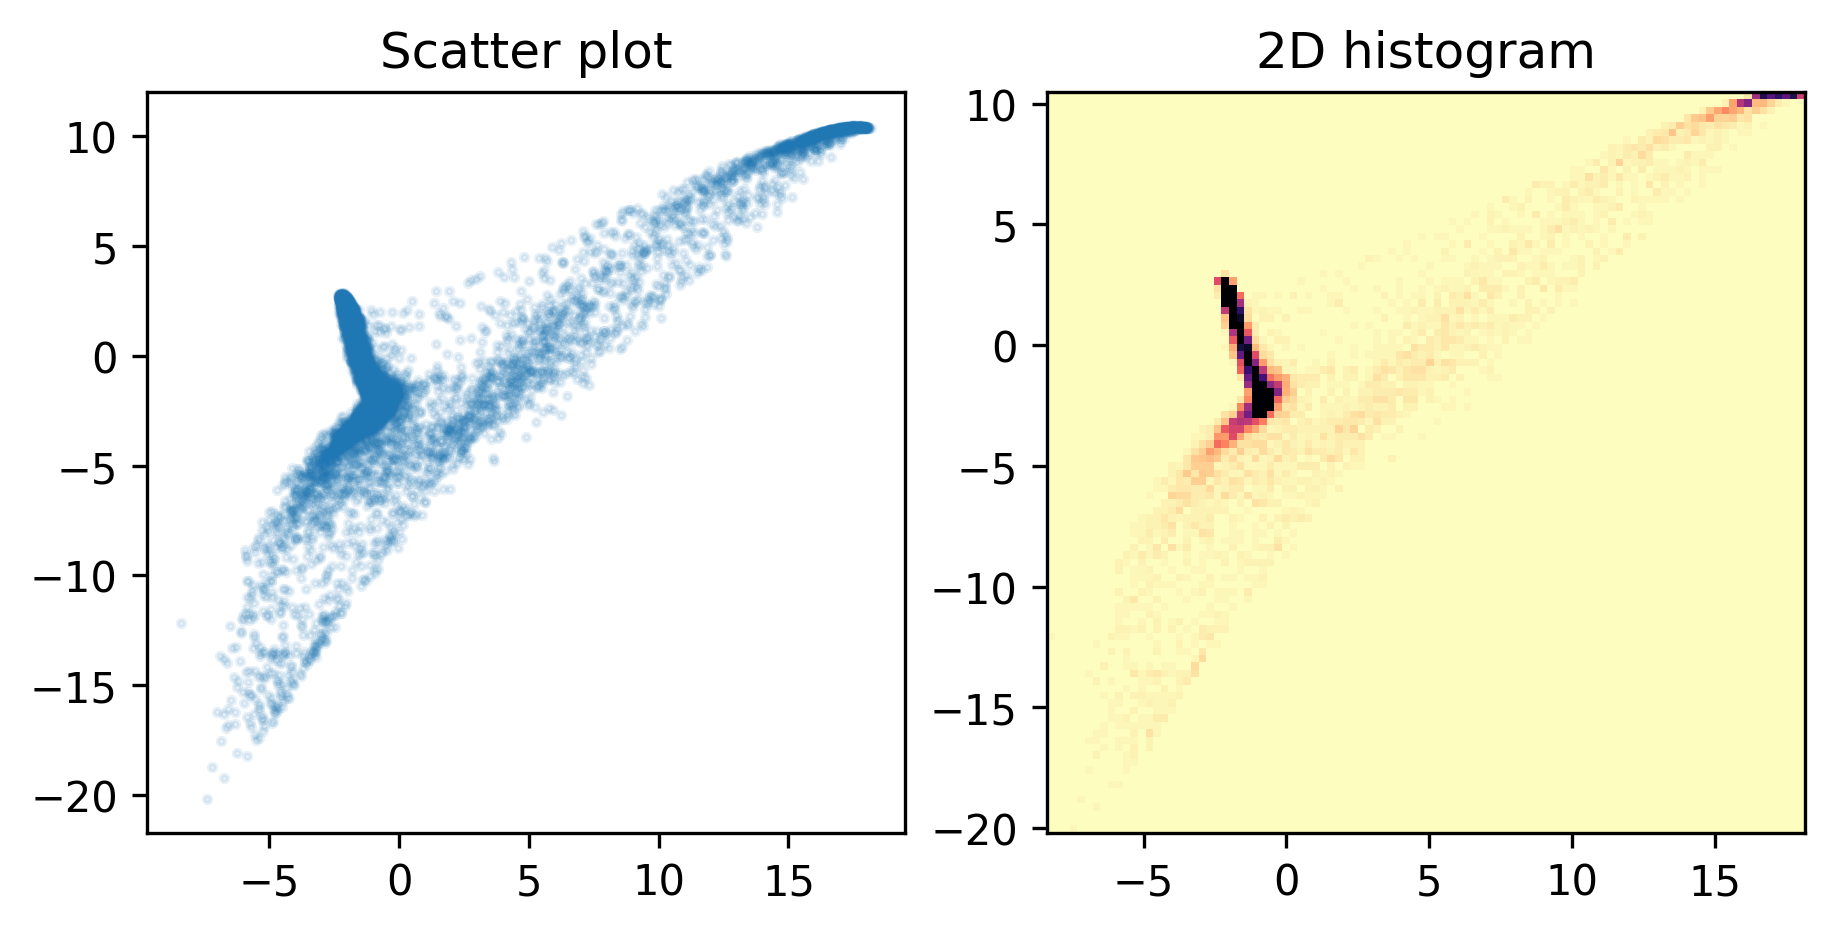

In [20]:
fig = plt.figure(figsize=[6,3], layout='constrained', dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# Scatter plot
ax1 = fig.add_subplot(spec[0, 0])
ax1.scatter(embeddings_inference[:,0], embeddings_inference[:,1], s=3, alpha=0.1)
ax1.set_title('Scatter plot')

# 2D histogram
ax2 = fig.add_subplot(spec[0, 1])
histout = np.histogram2d(embeddings_inference[:,0], embeddings_inference[:,1], bins=50)
ax2.hist2d(embeddings_inference[:,0], embeddings_inference[:,1], bins=100, cmap=plt.cm.magma_r, vmax=np.percentile(histout[0], 99))
ax2.set_title('2D histogram');